In [1]:
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy_ext as npe
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson

from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

import seaborn as sns

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H

# Setup
Read file with a selection of patients according to the following criteria:
* age >= 18 years
* ventilated for >= 24 hours
* length of ICU stay >= 72 hours
* known hospital mortality or 90-day-mortality

Data is assumed to be sampled and/or aggregated by periods of 4 hours for the entire ICU stay, i.e. including after and prior to mechanical ventilation.

In [2]:
file = 'data/ventilatedpatients.csv'
seed = 4
np.random.seed(seed)
random.seed(seed)

In [3]:
df = pd.read_csv(file)

In [4]:
df.describe()

,icustay_id,subject_id,hadm_id,admission_age,weight,adult_ibw,elixhauser_vanwalraven,sofa,sirs,gcs,...,vaso_total,iv_total,cum_fluid_balance,peep,tidal_volume,volume_controlled,plateau_pressure,height,vent_num,vent_duration_h
count,655511.000000,655511.000000,655511.000000,655511.000000,6.074500e+05,578222.000000,151920.000000,655511.000000,655511.000000,530701.000000,...,74411.000000,563031.000000,631969.000000,434476.000000,434165.000000,237904.0,125054.000000,578222.000000,367756.0,367756.000000
mean,250224.902655,32425.564384,150451.764811,70.383044,2.065581e+02,63.489246,9.869688,4.527715,1.129746,9.864654,...,1.824198,338.898801,-17525.159383,7.060447,514.528699,1.0,22.819280,169.548209,1.0,255.206777
std,28687.746902,27730.735504,28683.165908,44.717949,1.983471e+04,12.995944,7.701741,2.633949,0.897729,3.513073,...,16.028229,760.074027,38907.843496,3.406799,951.153481,0.0,6.589565,12.546390,0.0,242.078338
min,200003.000000,3.000000,100011.000000,18.057966,7.400000e+00,-1.228000,-10.000000,0.000000,0.000000,3.000000,...,0.001000,0.000000,-800783.548943,-9.500000,0.000000,1.0,0.000000,101.600000,1.0,24.000000
25%,225540.000000,11167.000000,126101.000000,52.651860,7.000000e+01,54.245600,5.000000,3.000000,0.000000,8.000000,...,0.080000,54.312500,-19953.600000,5.000000,422.333333,1.0,18.000000,162.560000,1.0,90.416667
50%,250665.000000,23157.000000,150361.000000,65.846363,8.268333e+01,63.868400,9.000000,4.000000,1.000000,10.000000,...,0.220000,131.266666,-9244.696152,5.000000,500.000000,1.0,22.000000,170.180000,1.0,185.000000
75%,274935.000000,51195.000000,175341.000000,76.860741,9.816471e+01,73.114000,15.000000,6.000000,2.000000,11.000000,...,0.554545,320.000000,-3003.122667,8.000000,590.000000,1.0,26.799999,177.800000,1.0,330.000000
max,299994.000000,99985.000000,199994.000000,308.522711,3.295995e+06,316.266000,44.000000,21.000000,4.000000,15.000000,...,3569.999979,290133.333333,533921.338370,101.000000,541442.000000,1.0,77.000000,445.000000,1.0,1762.000000


In [5]:
df.columns

Index(['icustay_id', 'subject_id', 'hadm_id', 'intime', 'outtime',
       'start_time', 'admission_age', 'gender', 'weight', 'adult_ibw',
       'icu_readmission', 'elixhauser_vanwalraven', 'sofa', 'sirs', 'gcs',
       'heartrate', 'sysbp', 'diasbp', 'meanbp', 'shockindex', 'resprate',
       'tempc', 'spo2', 'potassium', 'sodium', 'chloride', 'glucose', 'bun',
       'creatinine', 'magnesium', 'calcium', 'ionizedcalcium', 'carbondioxide',
       'sgot', 'sgpt', 'bilirubin', 'albumin', 'hemoglobin', 'wbc', 'platelet',
       'ptt', 'pt', 'inr', 'ph', 'pao2', 'paco2', 'base_excess', 'bicarbonate',
       'lactate', 'pao2fio2ratio', 'mechvent', 'fio2', 'urineoutput',
       'vaso_total', 'iv_total', 'cum_fluid_balance', 'peep', 'tidal_volume',
       'volume_controlled', 'plateau_pressure', 'hospmort', 'mort90day',
       'dischtime', 'deathtime', 'hadmittime', 'hdischtime', 'height',
       'vent_num', 'vent_duration_h'],
      dtype='object')

## Preprocessing phase 1
Set some time stamps

In [6]:
timestamps = [
    'start_time',
    'intime',
    'outtime',
]
for col in timestamps:
    df[col] = pd.to_datetime(df[col])

df = df.sort_values(['icustay_id', 'start_time']).reset_index().drop(['index', ], axis=1)

In [32]:
def grouped_fill_between(df, colname, fill_value):
    def my_fill_between(group, colname, fill_value):
        group = group.sort_values('start_time')
        from_i = group[colname].first_valid_index()
        to_i = group[colname].last_valid_index()
        return group.loc[from_i:to_i][colname].fillna(fill_value)
    grouped = df.sort_values(['start_time', 'icustay_id']).groupby('icustay_id')
    grouped_filled = grouped.apply(lambda x: my_fill_between(x, colname, fill_value))
    return grouped_filled.reset_index().set_index('level_1')[colname]

df['vent_num_imp'] = grouped_fill_between(df, 'vent_num', 1.0)
df['vent_imp_step'] = df.groupby('icustay_id').vent_num_imp.cumsum()
df['vent_shift'] = df.vent_num_imp.shift(-1)

df['select_peine'] = (~df['vent_shift'].isna() | (df['vent_num_imp'] == 1.0 )) & (df['vent_imp_step'] <= 18.0)
df['select_peine_step'] = df.groupby('icustay_id').select_peine.cumsum()
df['select_peine_step_rev'] = df.sort_values(['icustay_id', 'start_time'], ascending=False).groupby('icustay_id').select_peine.cumsum()

In [33]:
df[['vent_num_imp', 'vent_num', 'select_peine', 'select_peine_step', 'select_peine_step_rev', 'start_time', 'icustay_id']]

,vent_num_imp,vent_num,select_peine,select_peine_step,select_peine_step_rev,start_time,icustay_id
0,1.0,1.0,True,1,18,2199-08-02 17:40:00,200003
1,1.0,1.0,True,2,17,2199-08-02 21:40:00,200003
2,1.0,1.0,True,3,16,2199-08-03 01:40:00,200003
3,1.0,1.0,True,4,15,2199-08-03 05:40:00,200003
4,1.0,1.0,True,5,14,2199-08-03 09:40:00,200003
...,...,...,...,...,...,...,...
655506,NaN,NaN,False,18,0,2114-12-15 03:55:00,299994
655507,NaN,NaN,False,18,0,2114-12-15 07:55:00,299994
655508,NaN,NaN,False,18,0,2114-12-15 11:55:00,299994
655509,NaN,NaN,False,18,0,2114-12-15 15:55:00,299994


Add the admission time for each icustay as ``start_time_icustay``

In [9]:
df = df.merge(df.groupby('icustay_id', as_index=False)['start_time'].min(), on='icustay_id', how='left').rename(
    columns={'start_time_x': 'start_time', 'start_time_y': 'start_time_icustay'})

Calculate length of stay at the ICU: LOS ICU and length of stay in hospital: LOS Hosp

In [10]:
# length of stay at ICU
df['los_icu'] = df.outtime - df.intime
# length of stay at hospital, LOS
df.loc[:, 'hadmittime'] = pd.to_datetime(df.hadmittime)
df.loc[:, 'hdischtime'] = pd.to_datetime(df.hdischtime)
df.loc[:, 'hadm_duration'] = df.hdischtime - df.hadmittime

# Analyze missing values

In [11]:
def print_missing_pct(dataframe, variables):
    """
    Formatted print of the number of NaNs in `dataframe` for each variable in `variables`.
    """
    ljust = max(map(len, variables))
    for var in variables:
        print('{} {}'.format(var.ljust(ljust), dataframe[var].isna().mean()))

## Demographics
Analyze the missing data per patient for demographics:
* Age
* Gender
* Weight (upon admission)
* ICU readmission
* Premorbidity as calculated by exlixhauser vanWalraven score by previous hospital stay

In [12]:
# Note that demographics do not change over time, so we can take any value. We take the first.
identifiers = ['icustay_id',]

patients = df.drop_duplicates(identifiers, keep='first')
print_missing_pct(patients, demographics)

admission_age          0.0
adult_ibw              0.16844389921675945
height                 0.16844389921675945
weight                 0.14494668302349722
icu_readmission        0.0
elixhauser_vanwalraven 0.7719165801641974
hospmort               0.0
mort90day              0.0
vent_duration_h        0.0


## Vital signs
Analyze missing data across the entire dataset for vital signs. These can be composed of both lab and chart data:
* SOFA: sequential organ failure, see [code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/severityscores/sofa.sql)
* SIRS: systemic inflammatory response syndrome (SIRS) score, see [code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/severityscores/sirs.sql)
* GCS: glascow coma score, see [code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/pivot/pivoted-gcs.sql)
* HR: heartrate, averaged over period
* SysBP: systolic blood pressure, averaged over period
* MeanBP: mean arterial pressure, averaged over period
* DiasBP: diastolic blood pressure, averaged over period
* Shock Index: SysBP / HeartRate, averaged over period
* RespRate: respiratory rate, averaged over period
* SpO2: blood oxygenation saturation, averaged over period
* TempC: temperature in Celsius, averaged over period

In [13]:
print_missing_pct(df, vital_sign_vars)

sofa       0.0
sirs       0.0
gcs        0.1904010764121426
heartrate  0.014463525402319717
sysbp      0.02505831328536058
meanbp     0.01860075574628038
diasbp     0.02509492594327174
shockindex 0.0324220341077419
resprate   0.01770374562745705
spo2       0.022300159722720137
tempc      0.09414792429112555


## Lab measurements
All are averaged over the time span
* potassium
* sodium
* chloride
* glucose
* bun: blood urea nitrogen
* creatinine
* magnesium
* calcium
* ionizedcalcium
* carbondioxide
* bilirubin
* albumin
* hemoglobin
* wbc: white blood cell count
* platelet: platelets count
* ptt: Partial Thromboplastin Time
* pt: Prothrombin Time
* inr: International Normalized Ratio
* ph
* pao2
* paco2
* base_ excess
* bicarbonate
* lactate
* pao2fio2ratio

In [14]:
print_missing_pct(df, lab_vars)

potassium      0.9541823096790137
sodium         0.9551327132572909
chloride       0.9554149358286894
glucose        0.9572211602856397
bun            0.9547269229654423
creatinine     0.9546292892110125
magnesium      0.9591738353742347
calcium        0.9635215885011845
ionizedcalcium 0.8316138096843532
carbondioxide  0.9404678182364598
bilirubin      0.9840429832603877
albumin        0.9886241420815212
hemoglobin     0.9581074917125724
wbc            0.9582112275766539
platelet       0.956298216200796
ptt            0.9627191610819651
pt             0.962415581126785
inr            0.962415581126785
ph             0.9391741709902656
pao2           0.9782612343652509
paco2          0.9443746939410628
base_excess    0.9454974821170049
bicarbonate    0.955997687300442
lactate        0.9629769752147561
pao2fio2ratio  0.9829079908651418


## Generic, non-ventilation-related treatment variables
* iv_total
* vaso_total
* urineoutput
* cum_fluid_balance: cumulated fluid balance since admission, incl. preadmission when available

These can be 'missing' due to not being applied (e.g. vasopressors)

In [15]:
print_missing_pct(df, treatment_vars)

iv_total          0.14108077515098907
vaso_total        0.8864839796738727
urineoutput       0.14516461203549597
cum_fluid_balance 0.035913966356018436


## Ventilation settings
* peep
* fio2
* tidal_volume
* mechvent

These can be 'missing' due to mechanical ventilation not being applied.

In [16]:
print_missing_pct(df, vent_vars)

peep         0.337194951724685
fio2         0.2614570922532192
tidal_volume 0.3376693907501171
mechvent     0.004730660507603991


## Guideline vars
Some variables are in the guideline but were not in the original feature selection:
* plateau_pressure

In [17]:
print_missing_pct(df, guideline_vars)

plateau_pressure 0.8092266948990939


## Frequency analysis per variable
We estimate whether a new observation/measurement is expected in the following way:
* for every given observation, we calculate the time it took to observe.

  Specifically, we calculate the time from the previous observation OR admission.
* define a distribution of time it takes to do an observation (mean/avg?)
* estimate the expectation of a new probability based on this

In [18]:
def tukeys_fence(series, includena=True):
    q1, q3 = series.quantile(.25), series.quantile(.75)
    iqr = q3 - q1
    lower_fence, upper_fence = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    valuefilter = (series > lower_fence) & (series < upper_fence)
    if includena:
        return valuefilter | series.isna()
    else:
        return valuefilter
    

def ceil_to_nearest_multiple(n, multiple=SAMPLE_TIME_H):
    """
    Rounds `n` up to nearest `multiple`.
    """
    return multiple * math.ceil(n / multiple)

def get_poisson_cutoff(data, quantile=.99, label='Data', sample_time=SAMPLE_TIME_H, plot=False):
    """
    Returns the value so that `quantile` % of the `data` lies below that value.
    """
    data = data - 1
    # the bins should be of integer width, because poisson is an integer distribution
    bins = np.arange(np.nanmax(data)) - 0.5
    entries, bin_edges = np.histogram(data, bins=bins, density=True)

    # calculate bin centres
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    def fit_function(k, lamb):
        '''poisson function, parameter lamb is the fit parameter'''
        return poisson.pmf(k, lamb)

    # fit with curve_fit
    parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)
    cdf = poisson.cdf(np.arange(np.nanmax(data)), *parameters)
    cutoff = len(cdf[cdf < quantile])
    
    if plot:
        plt.hist(data, bins=bins, density=True, label=label)
        x_plot = np.arange(0, np.nanmax(data))
        axs = plt.plot(
            x_plot,
            fit_function(x_plot, *parameters),
            marker='o', linestyle='',
            label='poisson fit'
        )
        ax = plt.gca()
        plt.xlabel('x4 hours')
        plt.title("{}@{}: {}, max={}".format(label, quantile, cutoff*sample_time,np.nanmax(data)*sample_time))
        plt.legend()
        plt.vlines(cutoff, 0, max(entries)*1.1, colors=['black'])
        plt.show()
    
    return cutoff

def observation_durations(data, colname, groupby='icustay_id', sample_time=SAMPLE_TIME_H, scope_filter=None):
    """
    Returns the duration from admission or the previous measurements for each measurement of `colname` in `data`, for admissions identified by the `groupby` column and sample frequency of `sample_time`.
    """
    if scope_filter is None:
        scope_filter = pd.Series([True,] * data.shape[0])
    # initialize a copy of the `data` dataframe with some placeholder columns
    temp_df = pd.DataFrame.from_dict({
        'icustay_id': data.icustay_id,
        'timestamp': data.start_time,
        'timestamp_icustay': data.start_time_icustay,
        colname: data[colname],
        't_start': np.nan,
        'ages': pd.NaT,
    })
    # first set icu admission times as start time
    temp_df.loc[temp_df.timestamp == temp_df.timestamp_icustay, 't_start'] = temp_df[temp_df.timestamp == temp_df.timestamp_icustay].timestamp
    # then add timings of observations of variable in `colname`
    temp_df.loc[~temp_df[colname].isna(), 't_start'] = temp_df[~temp_df[colname].isna()].timestamp
    # now forward fill per icustay
    temp_df['t_start'] = temp_df.groupby(groupby)['t_start'].ffill()
    # and shift back by 1 time step per icustay
    temp_df['t_start'] = temp_df.groupby(groupby)['t_start'].shift()
    # and calculate the time from [previous observation|admission] until this observation
    temp_df.loc[~temp_df[colname].isna(), 'duration'] = pd.to_datetime(temp_df.timestamp) - pd.to_datetime(temp_df.t_start)
    # set time of first measurement to zero
    temp_df.loc[(temp_df['timestamp'] == temp_df['timestamp_icustay']) & ~temp_df[colname].isna()] = pd.Timedelta(0, 'hours')
    # add the length of time window to duration
    return temp_df[(~data[colname].isna() & scope_filter)]['duration'] + pd.Timedelta(sample_time, 'hours')

def observation_durations_ventstart(data, colname, groupby='icustay_id', sample_time=SAMPLE_TIME_H, scope_filter=None):
    """
    Returns the duration from admission or the previous measurements for each measurement of `colname` in `data`, for admissions identified by the `groupby` column and sample frequency of `sample_time`.
    """
    if scope_filter is None:
        scope_filter = pd.Series([True,] * data.shape[0])
    # initialize a copy of the `data` dataframe with some placeholder columns
    temp_df = pd.DataFrame.from_dict({
        'icustay_id': data.icustay_id,
        'timestamp': data.start_time,
        'timestamp_icustay': data.start_time_icustay,
        colname: data[colname],
        't_start': np.nan,
        'ages': pd.NaT,
        'mechvent_start_peine': (data.mechvent_start_peine == 1.0).fillna(False),
    })

    # first add timings of observations of variable in `colname`
    temp_df.loc[~temp_df[colname].isna(), 't_start'] = temp_df[~temp_df[colname].isna()].timestamp
    # forward fill, first pass
    temp_df.t_start.ffill()
    # then set the ventilation start as start time, if it is still missing
    temp_df.loc[temp_df.t_start.isna() & (temp_df.mechvent_start_peine), 't_start'] = temp_df[temp_df.t_start.isna() & (temp_df.mechvent_start_peine)].timestamp
    # now forward fill per icustay
    temp_df['t_start'] = temp_df.groupby(groupby)['t_start'].ffill()
    # and shift back by 1 time step per icustay
    temp_df['t_start'] = temp_df.groupby(groupby)['t_start'].shift()
    # and calculate the time from [previous observation|admission] until this observation
    temp_df.loc[~temp_df[colname].isna(), 'duration'] = pd.to_datetime(temp_df.timestamp) - pd.to_datetime(temp_df.t_start)
    # set time of first measurement to zero
    temp_df.loc[(temp_df.mechvent_start_peine) & ~temp_df[colname].isna()] = pd.Timedelta(0, 'hours')
    # add the length of time window to duration
    return temp_df[(~data[colname].isna() & scope_filter)]['duration'] + pd.Timedelta(sample_time, 'hours')

def get_cutoff_duration(data, colname, groupby='icustay_id', quantile=.99, sample_time=SAMPLE_TIME_H, plot=False, scope_filter=None):
    """
    Returns the duration so that `quantile` % of the `colname` measurements in `data` where obtained within that duration.
    """
    # obtain durations
#     durations = observation_durations(data, colname, groupby, scope_filter=scope_filter)
    durations = observation_durations_ventstart(data, colname, groupby, scope_filter=scope_filter)
    # convert to numpy array of hours
    duration_hours = (durations.dt.components.days * 24 + durations.dt.components.hours).to_numpy()
    # outlier removal using Tukey's fence
    durations = durations[tukeys_fence(durations)]
    return get_poisson_cutoff(duration_hours / sample_time, quantile, colname, plot=True) * sample_time

# Demographics
Some pre-selection demographics inspired by Table 1 in Peine et al.

In [19]:
# unique identifier columns
identifiers = ['icustay_id', 'subject_id', 'hadm_id',]
# columns with patient demographics information
demographics = ['admission_age', 'adult_ibw', 'height', 'weight', 'icu_readmission', 'elixhauser_vanwalraven', 'hospmort', 'mort90day', 'vent_duration_h']
patients = df.drop_duplicates(identifiers + demographics, keep='first')

In [20]:
patients.icustay_id.nunique()

10597

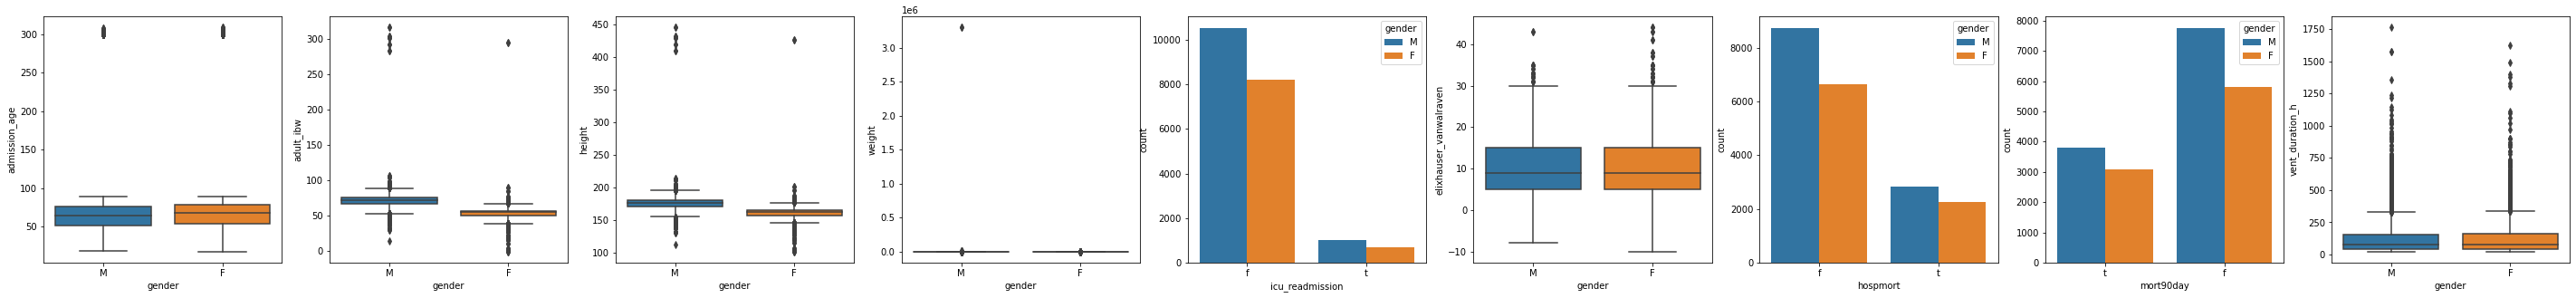

In [21]:
n_cols = len(demographics)
plt.subplots(1, len(demographics), figsize=(50,5))
for i in range(n_cols):
    plt.subplot(1, n_cols, i+1)
    if is_numeric_dtype(patients[demographics[i]]):
        sns.boxplot(data=patients, x='gender', y=demographics[i], orient='v')
    else:
        sns.countplot(data=patients, x=demographics[i], orient='v', hue='gender')

## Mechvent events
Create a single mechanical ventilation event per icustay.
Peine et. al simply sample the first recorded mechvent event.
- for each patient:
   - count each consecutive mechvent using mechvent_start_peine
   - assign this count label to each timestep at which mechvent_peine is true
   - calculate timestep before and 18 (=72/4) timesteps after onset of mechanical ventilation
   - filter by these calculated timesteps

<AxesSubplot:>

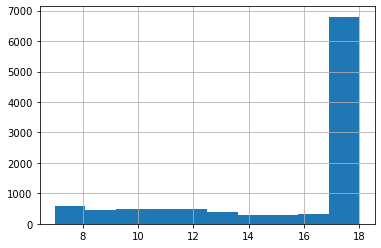

In [35]:
df.groupby('icustay_id')['select_peine_step'].max().hist()
df['select_peine_star

# Imputation
Steps according to Peine et al.
* Time-windowed sample-and-hold e.g. forward-fill.

  Windows sizes were determined using a frequency analysis of the dataset, producing the frequency of production of a new datapoint (per variable)
* K-nearest neighbor imputation with imputation and SVD
* If >50% of missing data, discard (<1% of cohort)
* Test correlation between data and probability distribution of missing values for each of the 44 features.
  Here, GCS was associated with highest p-value of 0.08 -> hence distinguish missing-at-random from missing-completely-at-random and not-missed-at-random.

## Determine sample-and-hold window with frequency analysis

In [38]:
# def ffill_window(df, var, plot, scope_filter):
#     val = get_cutoff_duration(df, var, quantile=.99, plot=plot, scope_filter=scope_filter)
#     if not plot:
#         print('.', end='') # simple measure of progress
#     return val

# all_var_types = [
#     vital_sign_vars,
#     lab_vars,
#     treatment_vars,
#     vent_vars,
#     guideline_vars,
# ]
# all_vars = functools.reduce(operator.add, all_var_types)

# # NOTE: embarrasingly parallel, can be sped up with e.g. joblib.Parallel
# ffill_windows_statistical = {var: ffill_window(df, var, True, df['select_peine']) for var in all_vars}

## Clinically informed sample-and-hold windows

In [39]:
inf = None
ffill_windows_clinical = {
    'sofa': 24 / SAMPLE_TIME_H,
    'sirs': 24 / SAMPLE_TIME_H,
    'gcs': inf,
    'heartrate': inf,
    'sysbp': inf,
    'meanbp': inf,
    'diasbp': inf,
    'shockindex': inf,
    'resprate': inf,
    'spo2': inf,
    'tempc': inf,
    'potassium': inf,
    'sodium': inf,
    'chloride': inf,
    'glucose': inf,
    'bun': inf,
    'creatinine': inf,
    'magnesium': inf,
    'calcium': inf,
    'ionizedcalcium': 8 / SAMPLE_TIME_H,
    'carbondioxide': inf,
    'bilirubin': inf,
    'albumin': inf,
    'hemoglobin': inf,
    'wbc': inf,
    'platelet': inf,
    'ptt': inf,
    'pt': inf,
    'inr': inf,
    'ph': inf,
    'pao2': inf,
    'paco2': inf,
    'base_excess': inf,
    'bicarbonate': inf,
    'lactate': inf,
    'pao2fio2ratio': inf,
    'iv_total': 8 / SAMPLE_TIME_H,
    'vaso_total': 24 / SAMPLE_TIME_H,
    'urineoutput': 8 / SAMPLE_TIME_H,
    'cum_fluid_balance': 8 / SAMPLE_TIME_H,
    'peep': 8 / SAMPLE_TIME_H,
    'fio2': 8 / SAMPLE_TIME_H,
    'tidal_volume': 8 / SAMPLE_TIME_H,
    'mechvent': 8 / SAMPLE_TIME_H,
    'plateau_pressure': 8 / SAMPLE_TIME_H
}

## Impute by sample-and-hold

In [40]:
for var in all_vars:
    df[var + '_imp'] = df.groupby('icustay_id')[var].ffill(limit=ffill_windows_clinical[var])

imputed_vars = list(map(lambda x: x + '_imp', all_vars))

In [41]:
max_varname_len = max(map(len, all_vars))
print("{}: {}  {}  {}".format('VARNAME'.ljust(max_varname_len), 'MISSING', 'ORIGINAL', 'IMPUTED'))
for var in all_vars:
    missing = df[var].isna().sum() / df.shape[0]
    missing_imp = df[var + '_imp'].isna().sum() / df.shape[0]
    imputed = missing - missing_imp
    print("{}: {:.4f}   {:.4f}    {:.4f}".format(
        var.ljust(max_varname_len),
        missing_imp,
        missing,
        imputed))

VARNAME          : MISSING  ORIGINAL  IMPUTED
sofa             : 0.0000   0.0000    0.0000
sirs             : 0.0000   0.0000    0.0000
gcs              : 0.0146   0.1904    0.1758
heartrate        : 0.0061   0.0145    0.0084
sysbp            : 0.0063   0.0251    0.0187
meanbp           : 0.0062   0.0186    0.0124
diasbp           : 0.0064   0.0251    0.0187
shockindex       : 0.0069   0.0324    0.0255
resprate         : 0.0060   0.0177    0.0117
spo2             : 0.0063   0.0223    0.0160
tempc            : 0.0121   0.0941    0.0820
potassium        : 0.0207   0.9542    0.9335
sodium           : 0.0147   0.9551    0.9404
chloride         : 0.0120   0.9554    0.9434
glucose          : 0.0242   0.9572    0.9330
bun              : 0.0082   0.9547    0.9466
creatinine       : 0.0082   0.9546    0.9464
magnesium        : 0.0308   0.9592    0.9283
calcium          : 0.0824   0.9635    0.8812
ionizedcalcium   : 0.6630   0.8316    0.1686
carbondioxide    : 0.0763   0.9405    0.8642
bilirubin

# Missing values selection

In [45]:
selection = df[df['select_peine']]

max_varname_len = max(map(len, all_vars))
print("{}: {}  {}  {}".format('VARNAME'.ljust(max_varname_len), 'MISSING', 'ORIGINAL', 'IMPUTED'))
for var in all_vars:
    missing = selection[var].isna().sum() / selection.shape[0]
    missing_imp = selection[var + '_imp'].isna().sum() / selection.shape[0]
    imputed = missing - missing_imp
    print("{}: {:.4f}   {:.4f}    {:.4f}".format(
        var.ljust(max_varname_len),
        missing_imp,
        missing,
        imputed))

VARNAME          : MISSING  ORIGINAL  IMPUTED
sofa             : 0.0000   0.0000    0.0000
sirs             : 0.0000   0.0000    0.0000
gcs              : 0.0557   0.2008    0.1451
heartrate        : 0.0222   0.0255    0.0033
sysbp            : 0.0232   0.0356    0.0124
meanbp           : 0.0226   0.0274    0.0048
diasbp           : 0.0233   0.0356    0.0123
shockindex       : 0.0250   0.0400    0.0150
resprate         : 0.0221   0.0268    0.0047
spo2             : 0.0231   0.0324    0.0093
tempc            : 0.0408   0.0996    0.0588
potassium        : 0.0417   0.8185    0.7769
sodium           : 0.0390   0.8223    0.7833
chloride         : 0.0337   0.8234    0.7897
glucose          : 0.0476   0.8306    0.7829
bun              : 0.0256   0.8207    0.7950
creatinine       : 0.0256   0.8203    0.7947
magnesium        : 0.0702   0.8383    0.7681
calcium          : 0.1125   0.8555    0.7430
ionizedcalcium   : 0.5679   0.7618    0.1940
carbondioxide    : 0.0972   0.7642    0.6670
bilirubin

# Outlier removal
"Outliers were sorted out with univariate statistical approaches (Tukey's range test) and frequency analysis (90% CI)" according to Peine. Since Tukey's range test is a test for significantly different means between groups, they probably refer to Tukey's fences for outlier detection, which are defines 'non outlier' data as everything in the range ``[(first quartile - 1.5 IQR), (third quartile + 1.5 IQR)]``.


In [46]:
boolean_numeric_vars = {'mechvent'}
tukeys_fences = []
for var in all_vars:
    if pd.api.types.is_numeric_dtype(selection[var]) and var not in boolean_numeric_vars:
        selection.loc[:, var + '_in_tukeys_fence'] = tukeys_fence(selection[var])
        tukeys_fences += [var + '_in_tukeys_fence',]
        selection.loc[~selection[var + '_in_tukeys_fence'], var] = np.NaN
        selection.loc[~selection[var + '_in_tukeys_fence'], var + '_imp'] = np.NaN

<ipython-input-46-a14ffd6ff2ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.loc[:, var + '_in_tukeys_fence'] = tukeys_fence(selection[var])
<ipython-input-46-a14ffd6ff2ab>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.loc[~selection[var + '_in_tukeys_fence'], var] = np.NaN
<ipython-input-46-a14ffd6ff2ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

<ipython-input-46-a14ffd6ff2ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.loc[:, var + '_in_tukeys_fence'] = tukeys_fence(selection[var])
<ipython-input-46-a14ffd6ff2ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.loc[:, var + '_in_tukeys_fence'] = tukeys_fence(selection[var])
<ipython-input-46-a14ffd6ff2ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [47]:
# outlier removal for demographic data
ranges = {
    'weight': (25, 400),
    'admission_age': (18, 150),
}
for var in ranges:
    lower, upper = ranges[var]
    selection.loc[(selection[var] < lower) | (selection[var] > upper), var] = np.NaN

Remove patients with too many missing values

In [48]:
to_remove = ((selection[imputed_vars + demographics].isnull().groupby(df.icustay_id).mean().mean(axis=1)) > .5)
print("Removing {} / {} = {}% patients due to >50% missing values".format(to_remove.sum(), selection.shape[0], 100*to_remove.sum()/selection.shape[0]))
selection = selection[~selection.icustay_id.isin(to_remove[to_remove].index)]
selected_patients = selection.drop_duplicates(subset='icustay_id', keep='first')

print("Selection of {} timesteps for {} patients / mech vent events".format(selection.shape[0], selected_patients.shape[0]))

Removing 16 / 165499 = 0.009667732131311972% patients due to >50% missing values
Selection of 165275 timesteps for 10581 patients / mech vent events


In [49]:
df.mechvent.isna().sum() / df.shape[0]

0.004730660507603991

In [50]:
selection.mechvent.isna().sum() / selection.shape[0]

0.011477839963696869

# Train-test-validation split

Train-test-validation split
* Train: 60%
* Test: 20%
* Validation: 20%

In [51]:
train, test, validation = .6, .2, .2
assert (train + test + validation) == 1.0

train_split = train / (train + test)
test_split = test / (train + test)

precision = 1e8
assert (train_split + test_split) - 1.0 < precision
assert (train_split * (train + test)) - train < precision
assert (test_split * (train + test)) - test < precision

train_and_test_patients, validation_patients = train_test_split(selected_patients, test_size=0.2)
train_patients, test_patients = train_test_split(train_and_test_patients, test_size=test_split)

precision = 1.5
assert abs(train_patients.shape[0] - train * selected_patients.shape[0]) < precision
assert abs(validation_patients.shape[0] - validation * selected_patients.shape[0]) < precision
assert abs(test_patients.shape[0] - test * selected_patients.shape[0]) < precision

train_df = selection[selection.icustay_id.isin(train_patients.icustay_id)].copy()
test_df = selection[selection.icustay_id.isin(test_patients.icustay_id)].copy()
validation_df = selection[selection.icustay_id.isin(validation_patients.icustay_id)].copy()

# Scale & center for imputation w/ kNN

for k-means, data has to be scaled first.
k-Means imputation

In [52]:
# NOTE: mirror changes here in the unscaling logic in e.g. the Clustering & Analysis notebook
numeric_scaler = StandardScaler

df_stays = df.drop_duplicates(subset='icustay_id', keep='first')
scalers = {}

scaled_vars = []
for var in all_vars:
    if pd.api.types.is_numeric_dtype(selection[var]):
        ffilled_varname = var + '_imp'
        scaled_vars.append(ffilled_varname)

all_var_scaler = numeric_scaler()
scaled = all_var_scaler.fit_transform(train_df[scaled_vars])
scaled_test = all_var_scaler.transform(test_df[scaled_vars])
scaled_varnames = [var + '_scaled' for var in all_var_scaler.get_feature_names_out()]
train_df[scaled_varnames] = scaled
test_df[scaled_varnames] = scaled_test

demographics_scaled_vars = []
for var in demographics:
    if pd.api.types.is_numeric_dtype(train_df[var]):
        scaled_vars.append(var)
        demographics_scaled_vars.append(var)
        
demographics_scaler = numeric_scaler()
demographics_scaler.fit(df_stays[demographics_scaled_vars])
demo_scaled_varnames = [var + '_scaled' for var in demographics_scaler.get_feature_names_out()]
scaled = demographics_scaler.transform(train_df[demographics_scaled_vars])
scaled_test = demographics_scaler.transform(test_df[demographics_scaled_vars])
train_df[demo_scaled_varnames] = scaled
test_df[demo_scaled_varnames] = scaled_test

joblib.dump(scaled_varnames, 'scalers/train/clinical_std_varnames.bin', compress=True)
joblib.dump(all_var_scaler, "scalers/train/clinical_std_scaler.bin", compress=True)
joblib.dump(demo_scaled_varnames, 'scalers/train/demographics_std_varnames.bin', compress=True)
joblib.dump(demographics_scaler, "scalers/train/demographics_std_scaler.bin", compress=True)

['scalers/train/demographics_std_scaler.bin']

In [53]:
# Test that scaling did not impose any NAs
assert train_df['tempc_imp'].isna().sum() == train_df['tempc_imp_scaled'].isna().sum()
assert train_df['admission_age'].isna().sum() == train_df['admission_age_scaled'].isna().sum()

assert test_df['tempc_imp'].isna().sum() == test_df['tempc_imp_scaled'].isna().sum()
assert test_df['admission_age'].isna().sum() == test_df['admission_age_scaled'].isna().sum()

In [54]:
vars_to_impute = scaled_varnames + demo_scaled_varnames
knn_imputed_vars = list(map(lambda x: x + '_impknn', vars_to_impute))

imputer = KNNImputer() # use default of n=5, weights='uniform', metric='nan_euclidean'
imputed = imputer.fit_transform(train_df[vars_to_impute].to_numpy())
imputed_test = imputer.transform(test_df[vars_to_impute].to_numpy())
train_df.loc[:, knn_imputed_vars] = imputed
test_df.loc[:, knn_imputed_vars] = imputed_test

In [55]:
knn_imputed_vars

['sofa_imp_scaled_impknn',
 'sirs_imp_scaled_impknn',
 'gcs_imp_scaled_impknn',
 'heartrate_imp_scaled_impknn',
 'sysbp_imp_scaled_impknn',
 'meanbp_imp_scaled_impknn',
 'diasbp_imp_scaled_impknn',
 'shockindex_imp_scaled_impknn',
 'resprate_imp_scaled_impknn',
 'spo2_imp_scaled_impknn',
 'tempc_imp_scaled_impknn',
 'potassium_imp_scaled_impknn',
 'sodium_imp_scaled_impknn',
 'chloride_imp_scaled_impknn',
 'glucose_imp_scaled_impknn',
 'bun_imp_scaled_impknn',
 'creatinine_imp_scaled_impknn',
 'magnesium_imp_scaled_impknn',
 'calcium_imp_scaled_impknn',
 'ionizedcalcium_imp_scaled_impknn',
 'carbondioxide_imp_scaled_impknn',
 'bilirubin_imp_scaled_impknn',
 'albumin_imp_scaled_impknn',
 'hemoglobin_imp_scaled_impknn',
 'wbc_imp_scaled_impknn',
 'platelet_imp_scaled_impknn',
 'ptt_imp_scaled_impknn',
 'pt_imp_scaled_impknn',
 'inr_imp_scaled_impknn',
 'ph_imp_scaled_impknn',
 'pao2_imp_scaled_impknn',
 'paco2_imp_scaled_impknn',
 'base_excess_imp_scaled_impknn',
 'bicarbonate_imp_scaled

In [56]:
# Test that scaling did not impose any NAs
assert train_df['tempc_imp'].isna().sum() > train_df['tempc_imp_scaled_impknn'].isna().sum()
assert train_df['admission_age'].isna().sum() > train_df['admission_age_scaled_impknn'].isna().sum()

assert test_df['tempc_imp'].isna().sum() > test_df['tempc_imp_scaled_impknn'].isna().sum()
assert test_df['admission_age'].isna().sum() > test_df['admission_age_scaled_impknn'].isna().sum()

In [57]:
joblib.dump(imputer, "scalers/train/knn_imputer.bin", compress=True)

['scalers/train/knn_imputer.bin']

In [58]:
def adult_ibw(row):
    if row.gender == 'M':
        return 50 + 0.91 * (row.height - 152.4)
    elif row.gender == 'F':
        return 45 + 0.91 * (row.height - 152.4)
    else:
        return np.NaN


for df_name, df in (('train', train_df), ('test', test_df), ('validation', validation_df)):
    df['adult_ibw_imp_knn'] = df.apply(adult_ibw, axis=1)

In [59]:
for df_name, df in (('train', train_df), ('test', test_df), ('validation', validation_df)):
    df = df[~df['adult_ibw_imp_knn'].isna()]
    if df_name == 'train':
        df.to_csv('./data/{}_imputed.csv'.format(df_name))
    else:
        df.to_csv('./data/{}_ffilled.csv'.format(df_name))

In [60]:
train_df_l = pd.read_csv('./data/train_imputed.csv')
test_df_l = pd.read_csv('./data/test_imputed.csv')
val_df_l = pd.read_csv('./data/validation_ffilled.csv')

train_df_l.shape[0], test_df_l.shape[0], val_df_l.shape[0]

(84557, 19412, 27421)

In [61]:
selection = pd.concat([train_df_l, test_df_l, val_df_l])
selection['los_icu'] = pd.to_timedelta(selection['los_icu'])
selection['hadm_duration'] = pd.to_timedelta(selection['hadm_duration'])
selected_patients = selection.drop_duplicates(subset='icustay_id', keep='first')

# Population demographics

In [62]:
print("{:<30} {}".format("Included stays", selection.icustay_id.nunique()))
print("{:<30} {:.2f} +- ({:.2f}-{:.2f})".format(
    "Age, years median (q1-q3)",
    selected_patients.admission_age.median(),
    selected_patients.admission_age.quantile(.25),
    selected_patients.admission_age.quantile(.75)
))
print("{:<30} {:.2f} ±{:.2f}".format(
    "Adm. Weight mean ±std",
    selected_patients.weight.mean(),
    selected_patients.weight.std()
))
print("{:<30} {:.2f} ±{:.2f}".format(
    "Pred. IBW mean ±std",
    selected_patients.adult_ibw.mean(),
    selected_patients.adult_ibw.std()
))
gender_counts = selected_patients.gender.value_counts
print("{:<30} {} ({:.2f}%)".format("Female", (selected_patients.gender == 'F').sum(), 100*(selected_patients.gender == 'F').sum() / selected_patients.shape[0]))
print("{:<30} {} ({:.2f}%)".format("Male", (selected_patients.gender == 'M').sum(), 100*(selected_patients.gender == 'M').sum() / selected_patients.shape[0]))
print("{:<30} {:.2f}%".format("90-day mortality", (selected_patients.mort90day == 't').sum() / selected_patients.shape[0] / 0.01))
print("{:<30} {:.2f}%".format("hosp mortality", (selected_patients.hospmort == 't').sum() / selected_patients.shape[0] / 0.01))
los_icu_median_days = selected_patients.los_icu.median().components.days + selected_patients.los_icu.median().components.hours / 24
los_icu_q1_days =  selected_patients.los_icu.quantile(.25).components.days + selected_patients.los_icu.quantile(.25).components.hours / 24
los_icu_q3_days =  selected_patients.los_icu.quantile(.75).components.days + selected_patients.los_icu.quantile(.75).components.hours / 24
print("{:<30} {:.2f} ({:.2f}-{:.2f})".format(
    "LOS ICU median (q1-q3)",
    los_icu_median_days,
    los_icu_q1_days,
    los_icu_q3_days
))
los_hosp_median_days = selected_patients.hadm_duration.median().components.days + selected_patients.hadm_duration.median().components.hours / 24
los_hosp_q1_days =  selected_patients.hadm_duration.quantile(.25).components.days + selected_patients.hadm_duration.quantile(.25).components.hours / 24
los_hosp_q3_days =  selected_patients.hadm_duration.quantile(.75).components.days + selected_patients.hadm_duration.quantile(.75).components.hours / 24
print("{:<30} {:.2f} ({:.2f}-{:.2f})".format("LOS hosp median (q1-q3)", los_hosp_median_days, los_hosp_q1_days, los_icu_q3_days))
print("{:<30} {:.1f} ±{:.2f}".format("PEEP cmH2O mean ±std", selection.peep.mean(), selection.peep.std()))
print("{:<30} {:.2f} ±{:.2f}".format("FiO2, % mean ±std", selection.fio2.mean(), selection.fio2.std()))
selection['vt_mlkg'] = selection.tidal_volume / selection.adult_ibw_imp_knn
print("{:<30} {:.2f} ±{:.2f}".format("Vt, mL/kg (PIBW) mean ±std", selection['vt_mlkg'].mean(), selection['vt_mlkg'].std()))
print("{:<30} {:.2f} ±{:.2f}".format(
    "SOFA points @ adm. mean ±std",
    selected_patients.sofa.mean(),
    selected_patients.sofa.std()
))

Included stays                 7666
Age, years median (q1-q3)      65.78 +- (53.24-76.50)
Adm. Weight mean ±std          86.22 ±24.91
Pred. IBW mean ±std            63.22 ±13.08
Female                         3347 (43.66%)
Male                           4319 (56.34%)
90-day mortality               33.88%
hosp mortality                 25.37%
LOS ICU median (q1-q3)         7.67 (4.42-13.58)
LOS hosp median (q1-q3)        14.71 (8.67-13.58)
PEEP cmH2O mean ±std           6.4 ±2.20
FiO2, % mean ±std              45.65 ±7.43
Vt, mL/kg (PIBW) mean ±std     8.38 ±7.43
SOFA points @ adm. mean ±std   4.10 ±3.27


In [63]:
# 35,556 decision time instances according to peine et al, Table 2a Supplementary material.
selection.shape[0], selection.shape[0] / selected_patients.shape[0]

(131390, 17.13931646230107)

In [64]:
# paper reports inclusion of 35,556 decision time instances for MIMIC-III, this gives an average trajectory length of
35556 / 11443

3.107227125753736

In [65]:
35556 / (650 * 7**3)

0.1594797039694999

In [66]:
72 / 4

18.0

In [67]:
96858/35556 

2.724097198785015